### A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:
    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands.

<pre>
Steps we will follow in this exercise:

1. Reading, Understanding and visualizing the data
2. Preparing the data for modeling (dummy variable, train-test split and rescaling)
3. Training the model
4. Residual Analysis
5. Prediction and evaluation on the test set

### Section1: Reading, Understanding and visualizing the data

In [5]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [6]:
# statsmodels libraries

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [7]:
# sklearn libraries

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# sklearn libraries to assess error terms independence
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.stattools import durbin_watson

In [8]:
boom_bikes = pd.read_csv('day.csv')

In [9]:
boom_bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [10]:
data_dict = {
'instant': 'record index',
'dteday' : 'date',
'season' : 'season (1:spring, 2:summer, 3:fall, 4:winter)',
'yr' : 'year (0: 2018, 1:2019)',
'mnth' : 'month ( 1 to 12)',
'holiday' : 'weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)',
'weekday' : 'day of the week',
'workingday' : 'if day is neither weekend nor holiday is 1, otherwise is 0.',
'weathersit' : '\n 1 - Clear, Few clouds, Partly cloudy, Partly cloudy \n 2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\n 3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds \n 4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog',
'temp' : 'temperature in Celsius',
'feel_temp': 'feeling temperature in Celsius',
'humidity': 'humidity',
'windspeed': 'wind speed',
'casual': 'count of casual users',
'registered': 'count of registered users',
'cnt': 'count of total rental bikes including both casual and registered'
}

In [11]:
print(f'Shape of the Dataset:==> \nThe dataset contains a total of :: {boom_bikes.shape[0]} rows and :: {boom_bikes.shape[1]} columns')

Shape of the Dataset:==> 
The dataset contains a total of :: 730 rows and :: 16 columns


In [12]:
boom_bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [13]:
100*boom_bikes.isnull().mean()

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

<pre>
- There are no null values in any data instance or feature

In [14]:
boom_bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [15]:
# renaming the column for better redability
boom_bikes.rename(columns={'atemp':'feel_temp','hum':'humidity'},inplace=True)
boom_bikes.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feel_temp,humidity,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801


In [16]:
bike_df = boom_bikes.copy()

In [17]:
# Checking the value of duplicate values in the dataframe and dropping if any
bike_dups = len(bike_df[bike_df.duplicated()]) 
print('Checking the count of duplicate rows if any\n')
if bike_dups == 0:
    print(f'{bike_dups} duplicate values present. No cleanup needed for duplicates')
elif bike_dups > 0:
    print(f'Found : {bike_dups} : duplicate values in the dataframe. Performing a cleanup for these items now...........\n')
    bike_df.drop_duplicates(inplace=True)
    print('Post cleanup the duplicate value count is found to be :',len(bike_df[bike_df.duplicated()]))

Checking the count of duplicate rows if any

0 duplicate values present. No cleanup needed for duplicates


In [18]:
bike_df.nunique()

instant       730
dteday        730
season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
feel_temp     689
humidity      594
windspeed     649
casual        605
registered    678
cnt           695
dtype: int64

<pre>
=>Analysing the data dictionary for the dataset:
    
    Point 1 : Dropping the unwanted columns:
    
    - 'dteday' : an Object column which is already broken down further by the year and month column
    
    - 'casual': count of casual users and 'registered': count of registered users, both of which are already covered in the cnt column and therefore can be dropped
    
    - 'instant': only contains the record index

    Point 2: Columns with less unique values:
    
    - The columns with lower number of unique values help us understand that they have categorical values 

In [19]:
bike_df.drop(['instant', 'dteday','casual', 'registered'],axis=1,inplace=True)
bike_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feel_temp,humidity,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801


### Encoding the columns 

<pre>
Fetching the list of columns with unique values less than 15 that are showing a nature of categorical values. Moreover, review their definitions from the data dictionary

In [20]:
#segragating columns in numerical and categorical columns
# numerical cols
num_vars = ['temp','feel_temp','humidity','windspeed','cnt']

In [21]:
#categorical cols
cat_conv_list = bike_df.columns[bike_df.nunique() < 15].to_list()
for cat_conv_val in cat_conv_list:
    print(f'For feature "{cat_conv_val}" the definition is : {data_dict[cat_conv_val]}' )

For feature "season" the definition is : season (1:spring, 2:summer, 3:fall, 4:winter)
For feature "yr" the definition is : year (0: 2018, 1:2019)
For feature "mnth" the definition is : month ( 1 to 12)
For feature "holiday" the definition is : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
For feature "weekday" the definition is : day of the week
For feature "workingday" the definition is : if day is neither weekend nor holiday is 1, otherwise is 0.
For feature "weathersit" the definition is : 
 1 - Clear, Few clouds, Partly cloudy, Partly cloudy 
 2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
 4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [22]:
bike_df['season']=bike_df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})
print(bike_df['season'].value_counts())

season
fall      188
summer    184
spring    180
winter    178
Name: count, dtype: int64


In [23]:
bike_df['weathersit']=bike_df['weathersit'].map({1:'Clear',2:'Mist',3:'Light Snow',4:'Heavy Rain'})
print(bike_df['weathersit'].value_counts())

weathersit
Clear         463
Mist          246
Light Snow     21
Name: count, dtype: int64


In [24]:
bike_df['mnth']=bike_df['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
print(bike_df['mnth'].value_counts())

mnth
jan     62
mar     62
may     62
july    62
aug     62
oct     62
dec     62
apr     60
june    60
sep     60
nov     60
feb     56
Name: count, dtype: int64


In [25]:
bike_df['weekday']=bike_df['weekday'].map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})
print(bike_df['weekday'].value_counts())

weekday
sat    105
sun    105
mon    105
tue    104
thu    104
fri    104
wed    103
Name: count, dtype: int64


In [26]:
bike_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feel_temp,humidity,windspeed,cnt
0,spring,0,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801


In [27]:
bike_df[cat_conv_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      730 non-null    object
 1   yr          730 non-null    int64 
 2   mnth        730 non-null    object
 3   holiday     730 non-null    int64 
 4   weekday     730 non-null    object
 5   workingday  730 non-null    int64 
 6   weathersit  730 non-null    object
dtypes: int64(3), object(4)
memory usage: 40.1+ KB


In [28]:
# Converting the object type feature values into categorical string values

In [29]:
bike_df['season']=bike_df['season'].astype('category')
bike_df['weathersit']=bike_df['weathersit'].astype('category')
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    object  
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    object  
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   feel_temp   730 non-null    float64 
 9   humidity    730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(2), float64(4), int64(4), object(2)
memory usage: 58.9+ KB


### Visualizing the dataset

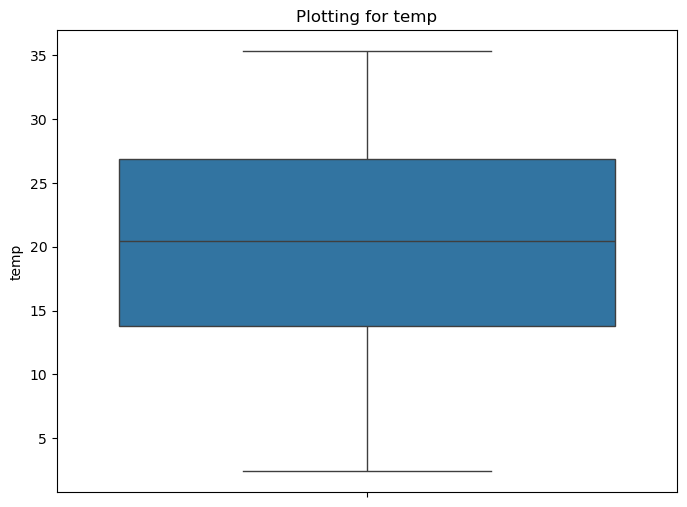

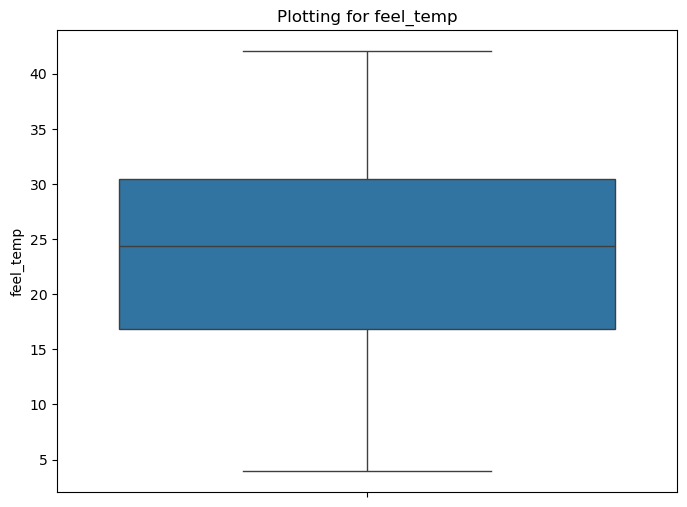

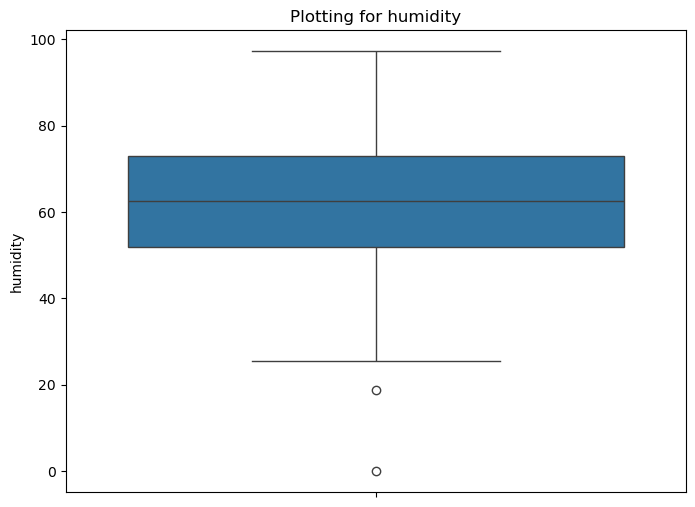

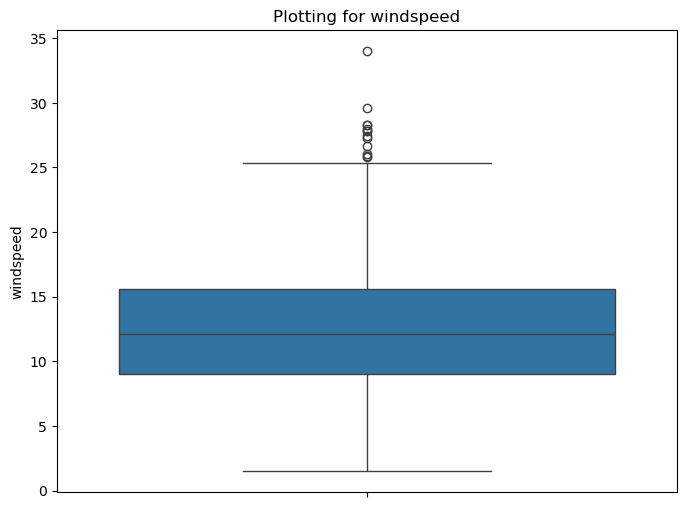

In [30]:
# Univariate analysis
# checking the presence of outliers on the features 
num_cols = ['temp', 'feel_temp', 'humidity', 'windspeed'] # list of numerical columns without the presence of target variable
for num_col in num_cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=bike_df,y=num_col)
    plt.title(f'Plotting for {num_col}')
    plt.show()

In [31]:
# Bivariate analysis

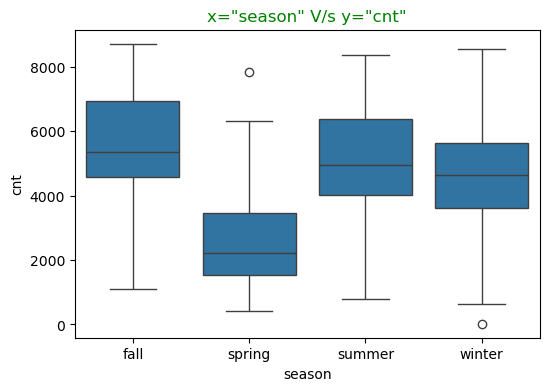

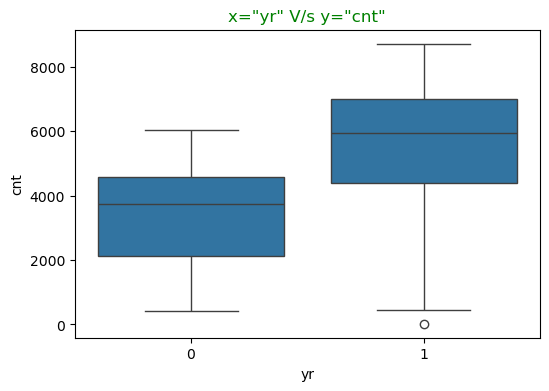

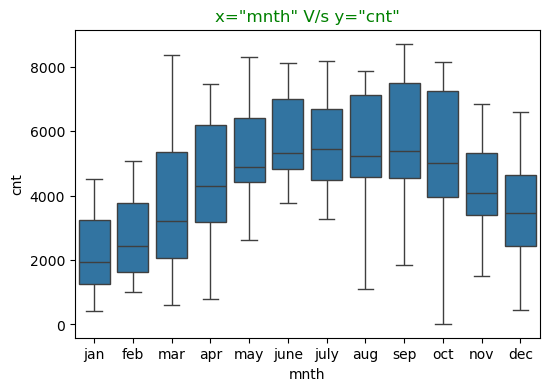

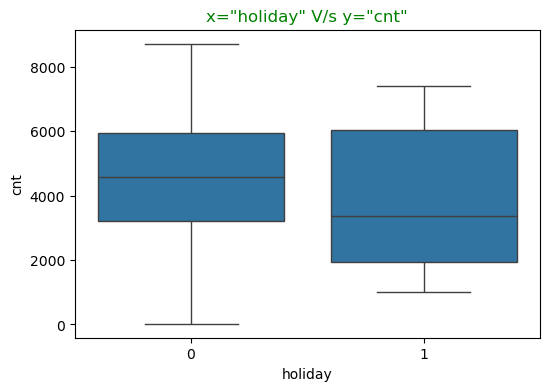

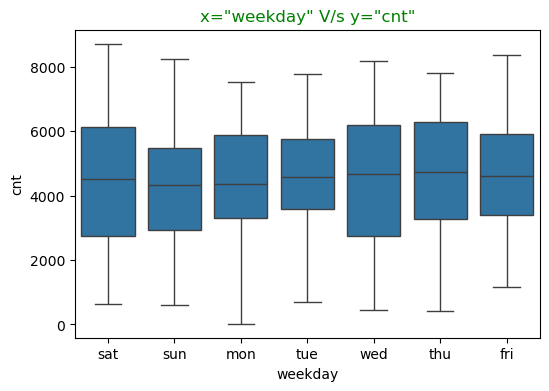

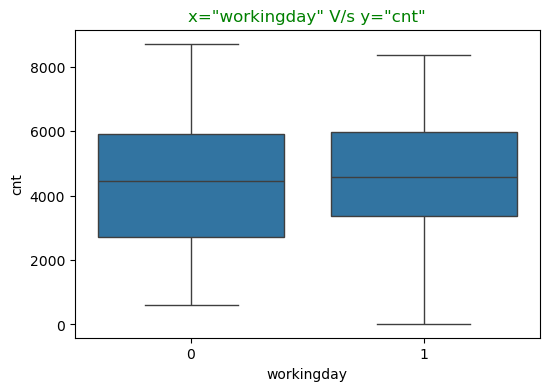

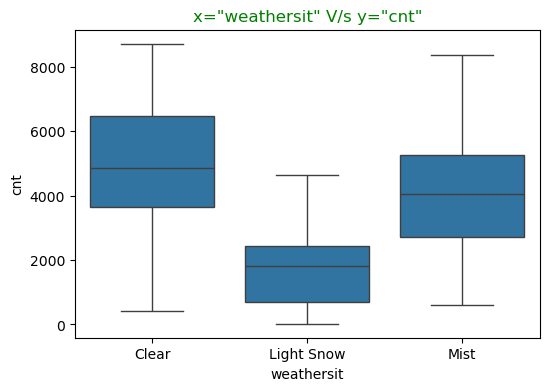

In [32]:
# Visualising and analysing the categorical columns again the target variable
for cat_conv_val in cat_conv_list:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=bike_df,x=cat_conv_val, y='cnt')
    plt.title(label=f'x="{cat_conv_val}" V/s y="cnt"',fontdict={'fontsize':12,'fontweight':5,'color':'Green'})
    plt.show()

In [33]:
def cat_col_plot(val):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(data=bike_df,y='cnt',x=val)
    plt.subplot(1,2,2)
    sns.barplot(data=bike_df,y='cnt',x=val,hue='yr',palette='Set1')
    plt.legend(labels=['2018','2019'])
    plt.show()

Plot number 1 : x="season" V/s y="cnt"


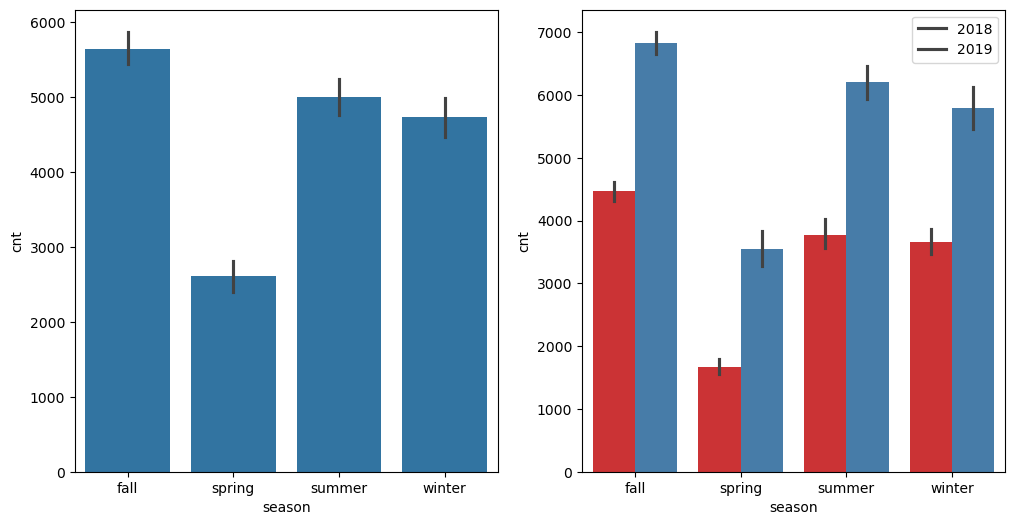

Plot number 2 : x="yr" V/s y="cnt"


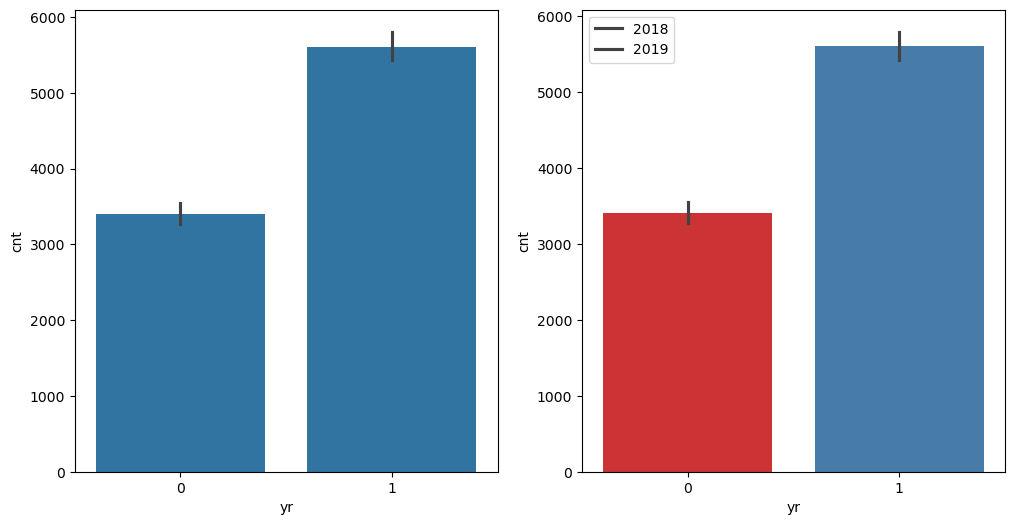

Plot number 3 : x="mnth" V/s y="cnt"


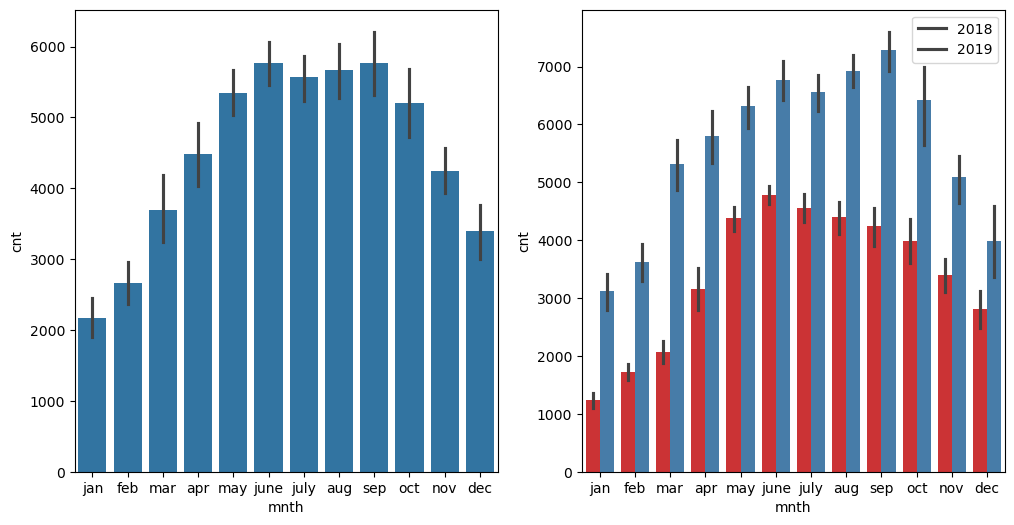

Plot number 4 : x="holiday" V/s y="cnt"


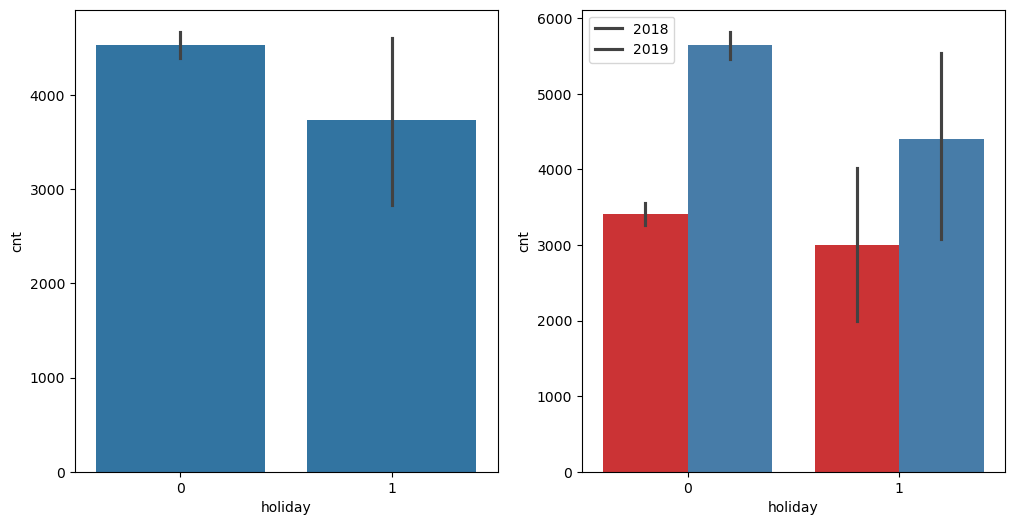

Plot number 5 : x="weekday" V/s y="cnt"


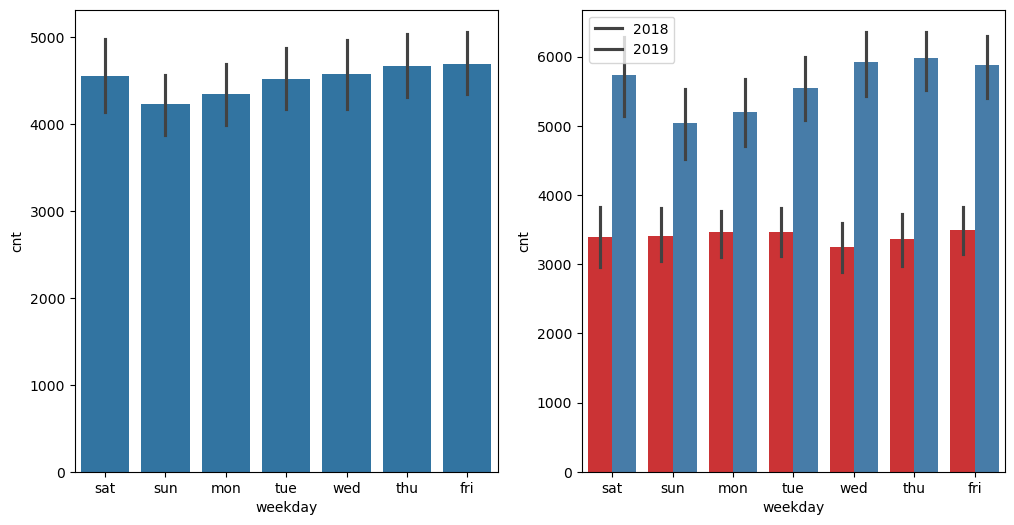

Plot number 6 : x="workingday" V/s y="cnt"


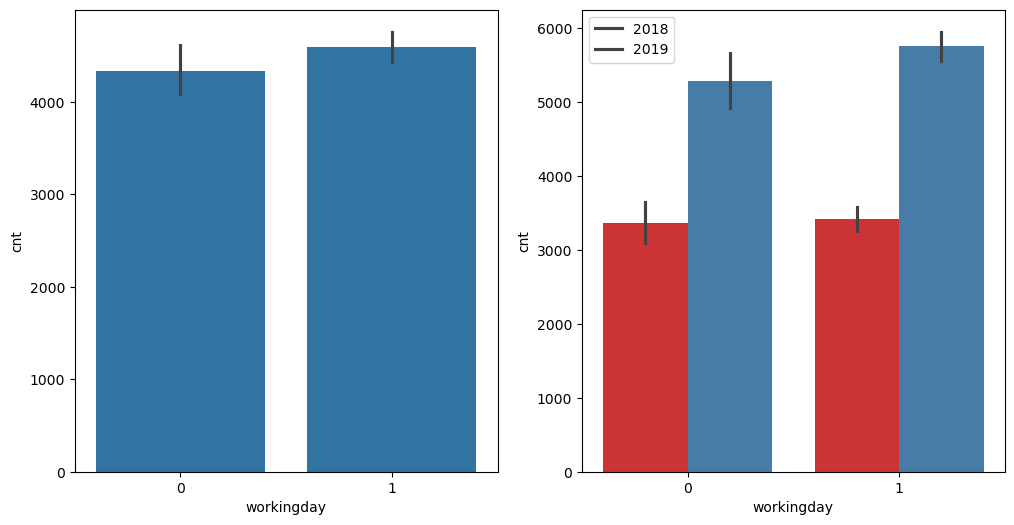

Plot number 7 : x="weathersit" V/s y="cnt"


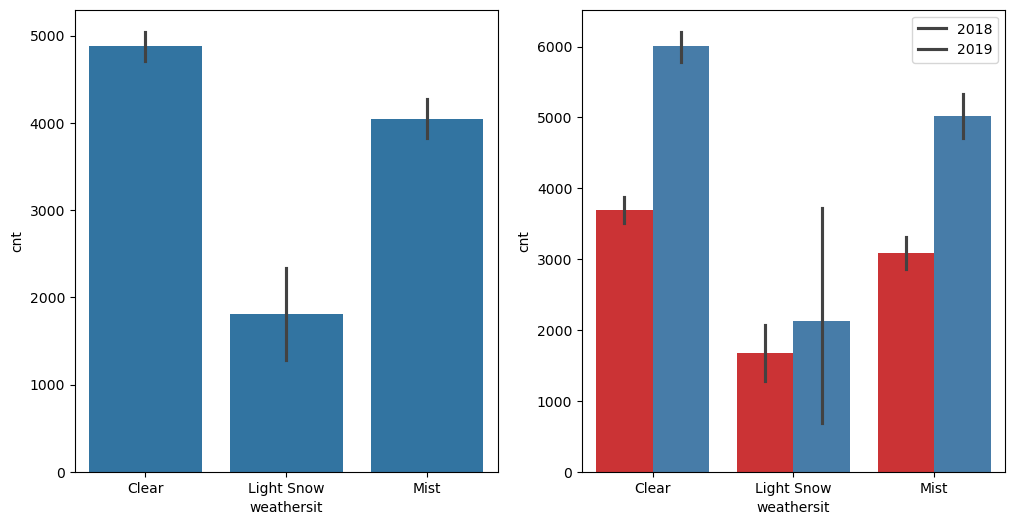

In [34]:
i=1 # indexing the plot numbers for explanation
for cat_conv_val in cat_conv_list:
    print(f'Plot number {i} : x="{cat_conv_val}" V/s y="cnt"')
    cat_col_plot(cat_conv_val)
    i+=1

In [35]:
# Multivariate analysis

In [36]:
#Checking the correlation between numerical variables
bike_df[num_vars].corr()

,temp,feel_temp,humidity,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
feel_temp,0.991696,1.000000,0.141512,-0.183876,0.630685
humidity,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


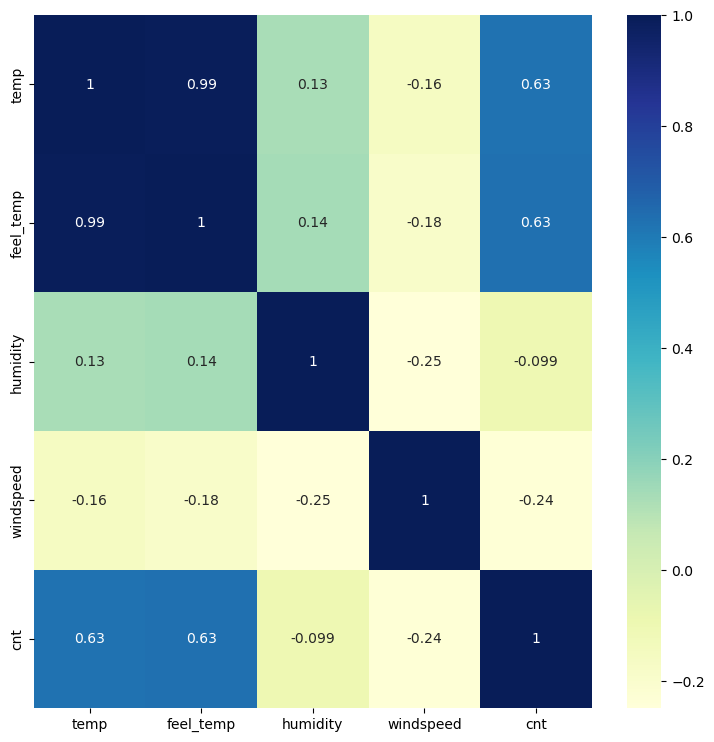

In [37]:
#plotting for correlation
plt.figure(figsize=(9,9))
sns.heatmap(bike_df[num_vars].corr(), annot=True, cmap='YlGnBu')
plt.show()

<pre>
There exists a linear relationship between temp and feel_temp. This implies that both the parameters are highly correlated '0.99' and cannot be used for modeling.
Further, we will drop the redundant columns using p-value and VIF to address multicollinearity.

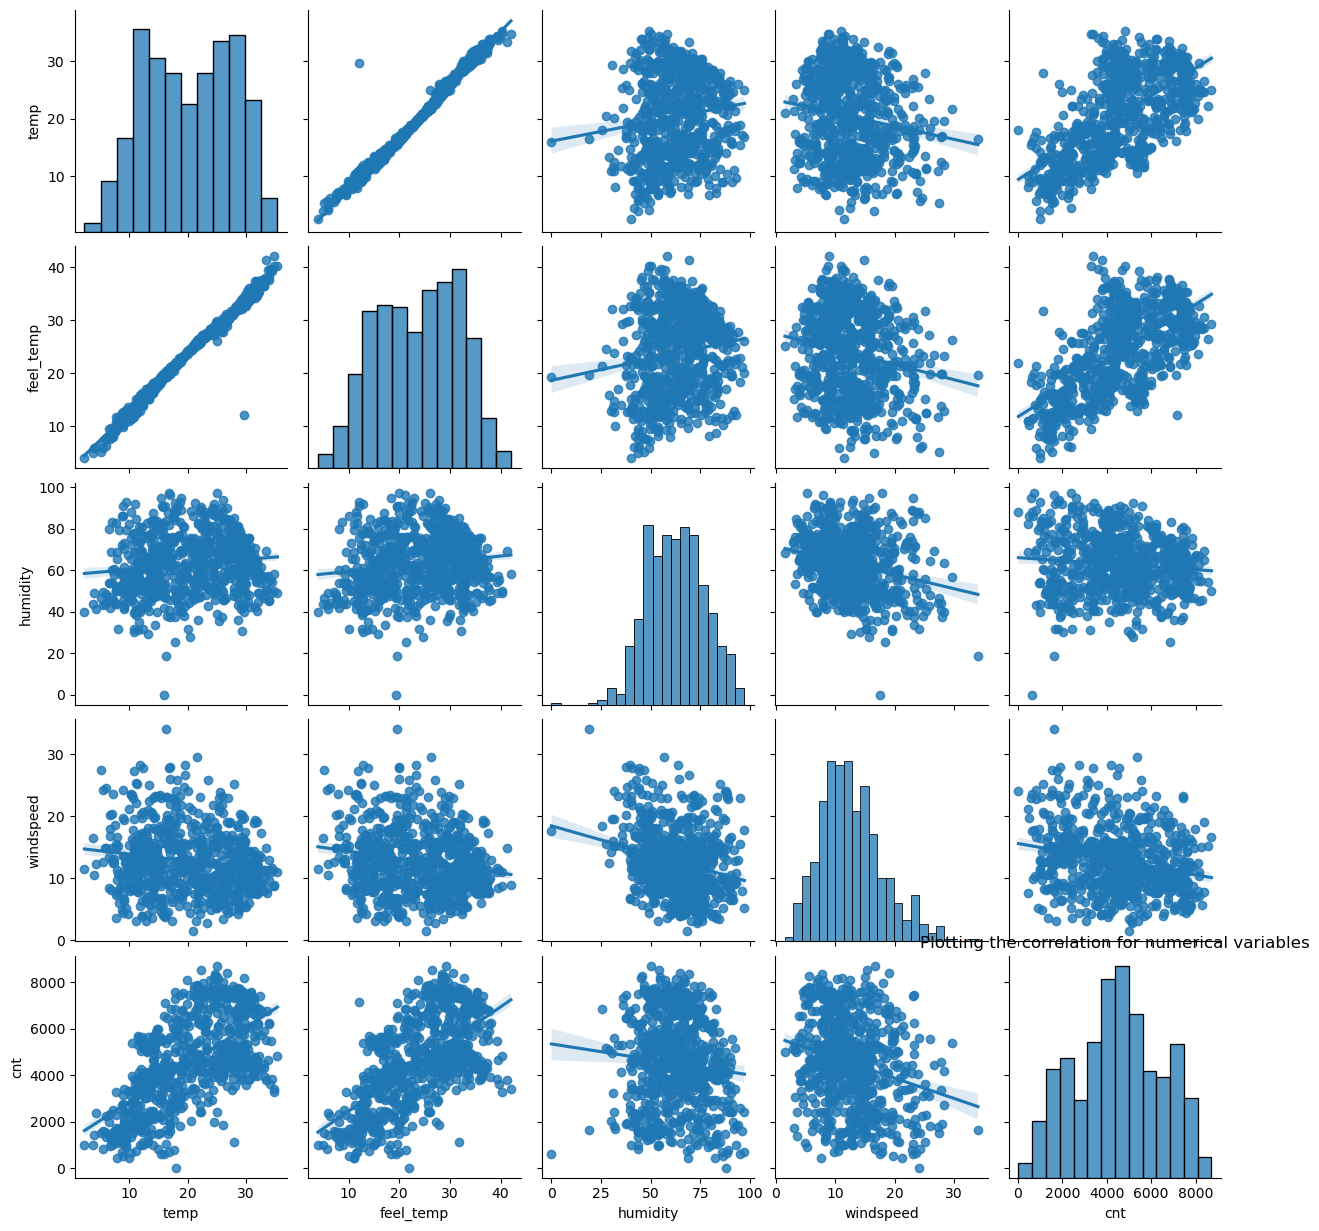

In [38]:
#Plotting a pair plot to check if the cnt[target variable] has a linear relationship with independent variables
sns.pairplot(data=bike_df,vars=num_vars, kind='reg')
plt.title('Plotting the correlation for numerical variables')
plt.show()

## Section 2: Preparing the data for modeling (dummy variable, train-test split and rescaling)

In [39]:
cat_conv_list

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [40]:
#Dummy variable creation for mnth, weekday, season and weathersit
mnth_df=pd.get_dummies(bike_df['mnth'],drop_first=True,dtype=int)
weekday_df=pd.get_dummies(bike_df['weekday'],drop_first=True,dtype=int)
season_df=pd.get_dummies(bike_df['season'],drop_first=True,dtype=int)
weathersit_df=pd.get_dummies(bike_df['weathersit'],drop_first=True,dtype=int)

In [41]:
# MErging all the dataframes along with dummy variables
boom_bike_df=pd.concat([bike_df,mnth_df,weekday_df,season_df,weathersit_df],axis=1)

In [42]:
boom_bike_df.head(2)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,feel_temp,humidity,...,sat,sun,thu,tue,wed,spring,summer,winter,Light Snow,Mist
0,spring,0,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,...,1,0,0,0,0,1,0,0,0,1
1,spring,0,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,...,0,1,0,0,0,1,0,0,0,1


In [43]:
boom_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    object  
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    object  
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   feel_temp   730 non-null    float64 
 9   humidity    730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
 12  aug         730 non-null    int32   
 13  dec         730 non-null    int32   
 14  feb         730 non-null    int32   
 15  jan         730 non-null    int32   
 16  july        730 non-null    int32   
 17  june        730 non-null    int32   
 18  mar         730 non-null    int32   
 19  may     

In [44]:
# Dropping columns mnth, weekday, season and weathersit as we have created dummy variables for same
boom_bike_df.drop(['mnth','weekday','season','weathersit'],axis=1,inplace=True)

In [45]:
boom_bike_df.shape

(730, 30)

### Performing train-test split

In [46]:
np.random.seed(0)
df_train, df_test = train_test_split(boom_bike_df, train_size=0.7, test_size=0.3, random_state=100)

In [47]:
#checking the shapes of train and test sets
print(f'The training set is a combination of : {df_train.shape} \nThe test set is a combination of {df_test.shape}')

The training set is a combination of : (510, 30) 
The test set is a combination of (219, 30)


In [48]:
df_train.head()

,yr,holiday,workingday,temp,feel_temp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,spring,summer,winter,Light Snow,Mist
653,1,0,1,19.201653,23.0423,55.8333,12.208807,7534,0,0,...,0,0,0,1,0,0,0,1,0,0
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,0,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,0,0,...,1,0,0,0,0,1,0,0,0,1
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,0,1,...,0,1,0,0,0,1,0,0,0,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,0,0,...,1,0,0,0,0,0,1,0,0,1


In [49]:
df_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'feel_temp', 'humidity',
       'windspeed', 'cnt', 'aug', 'dec', 'feb', 'jan', 'july', 'june', 'mar',
       'may', 'nov', 'oct', 'sep', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed',
       'spring', 'summer', 'winter', 'Light Snow', 'Mist'],
      dtype='object')

### Scaling

In [50]:
# Scaling all the non binary columns
num_vars

['temp', 'feel_temp', 'humidity', 'windspeed', 'cnt']

In [51]:
scaler = MinMaxScaler()

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [52]:
df_train.describe()

,yr,holiday,workingday,temp,feel_temp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,spring,summer,winter,Light Snow,Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.096078,0.084314,...,0.154902,0.143137,0.133333,0.131373,0.158824,0.243137,0.245098,0.24902,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.294988,0.278131,...,0.362166,0.350557,0.340268,0.338139,0.365870,0.429398,0.430568,0.43287,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


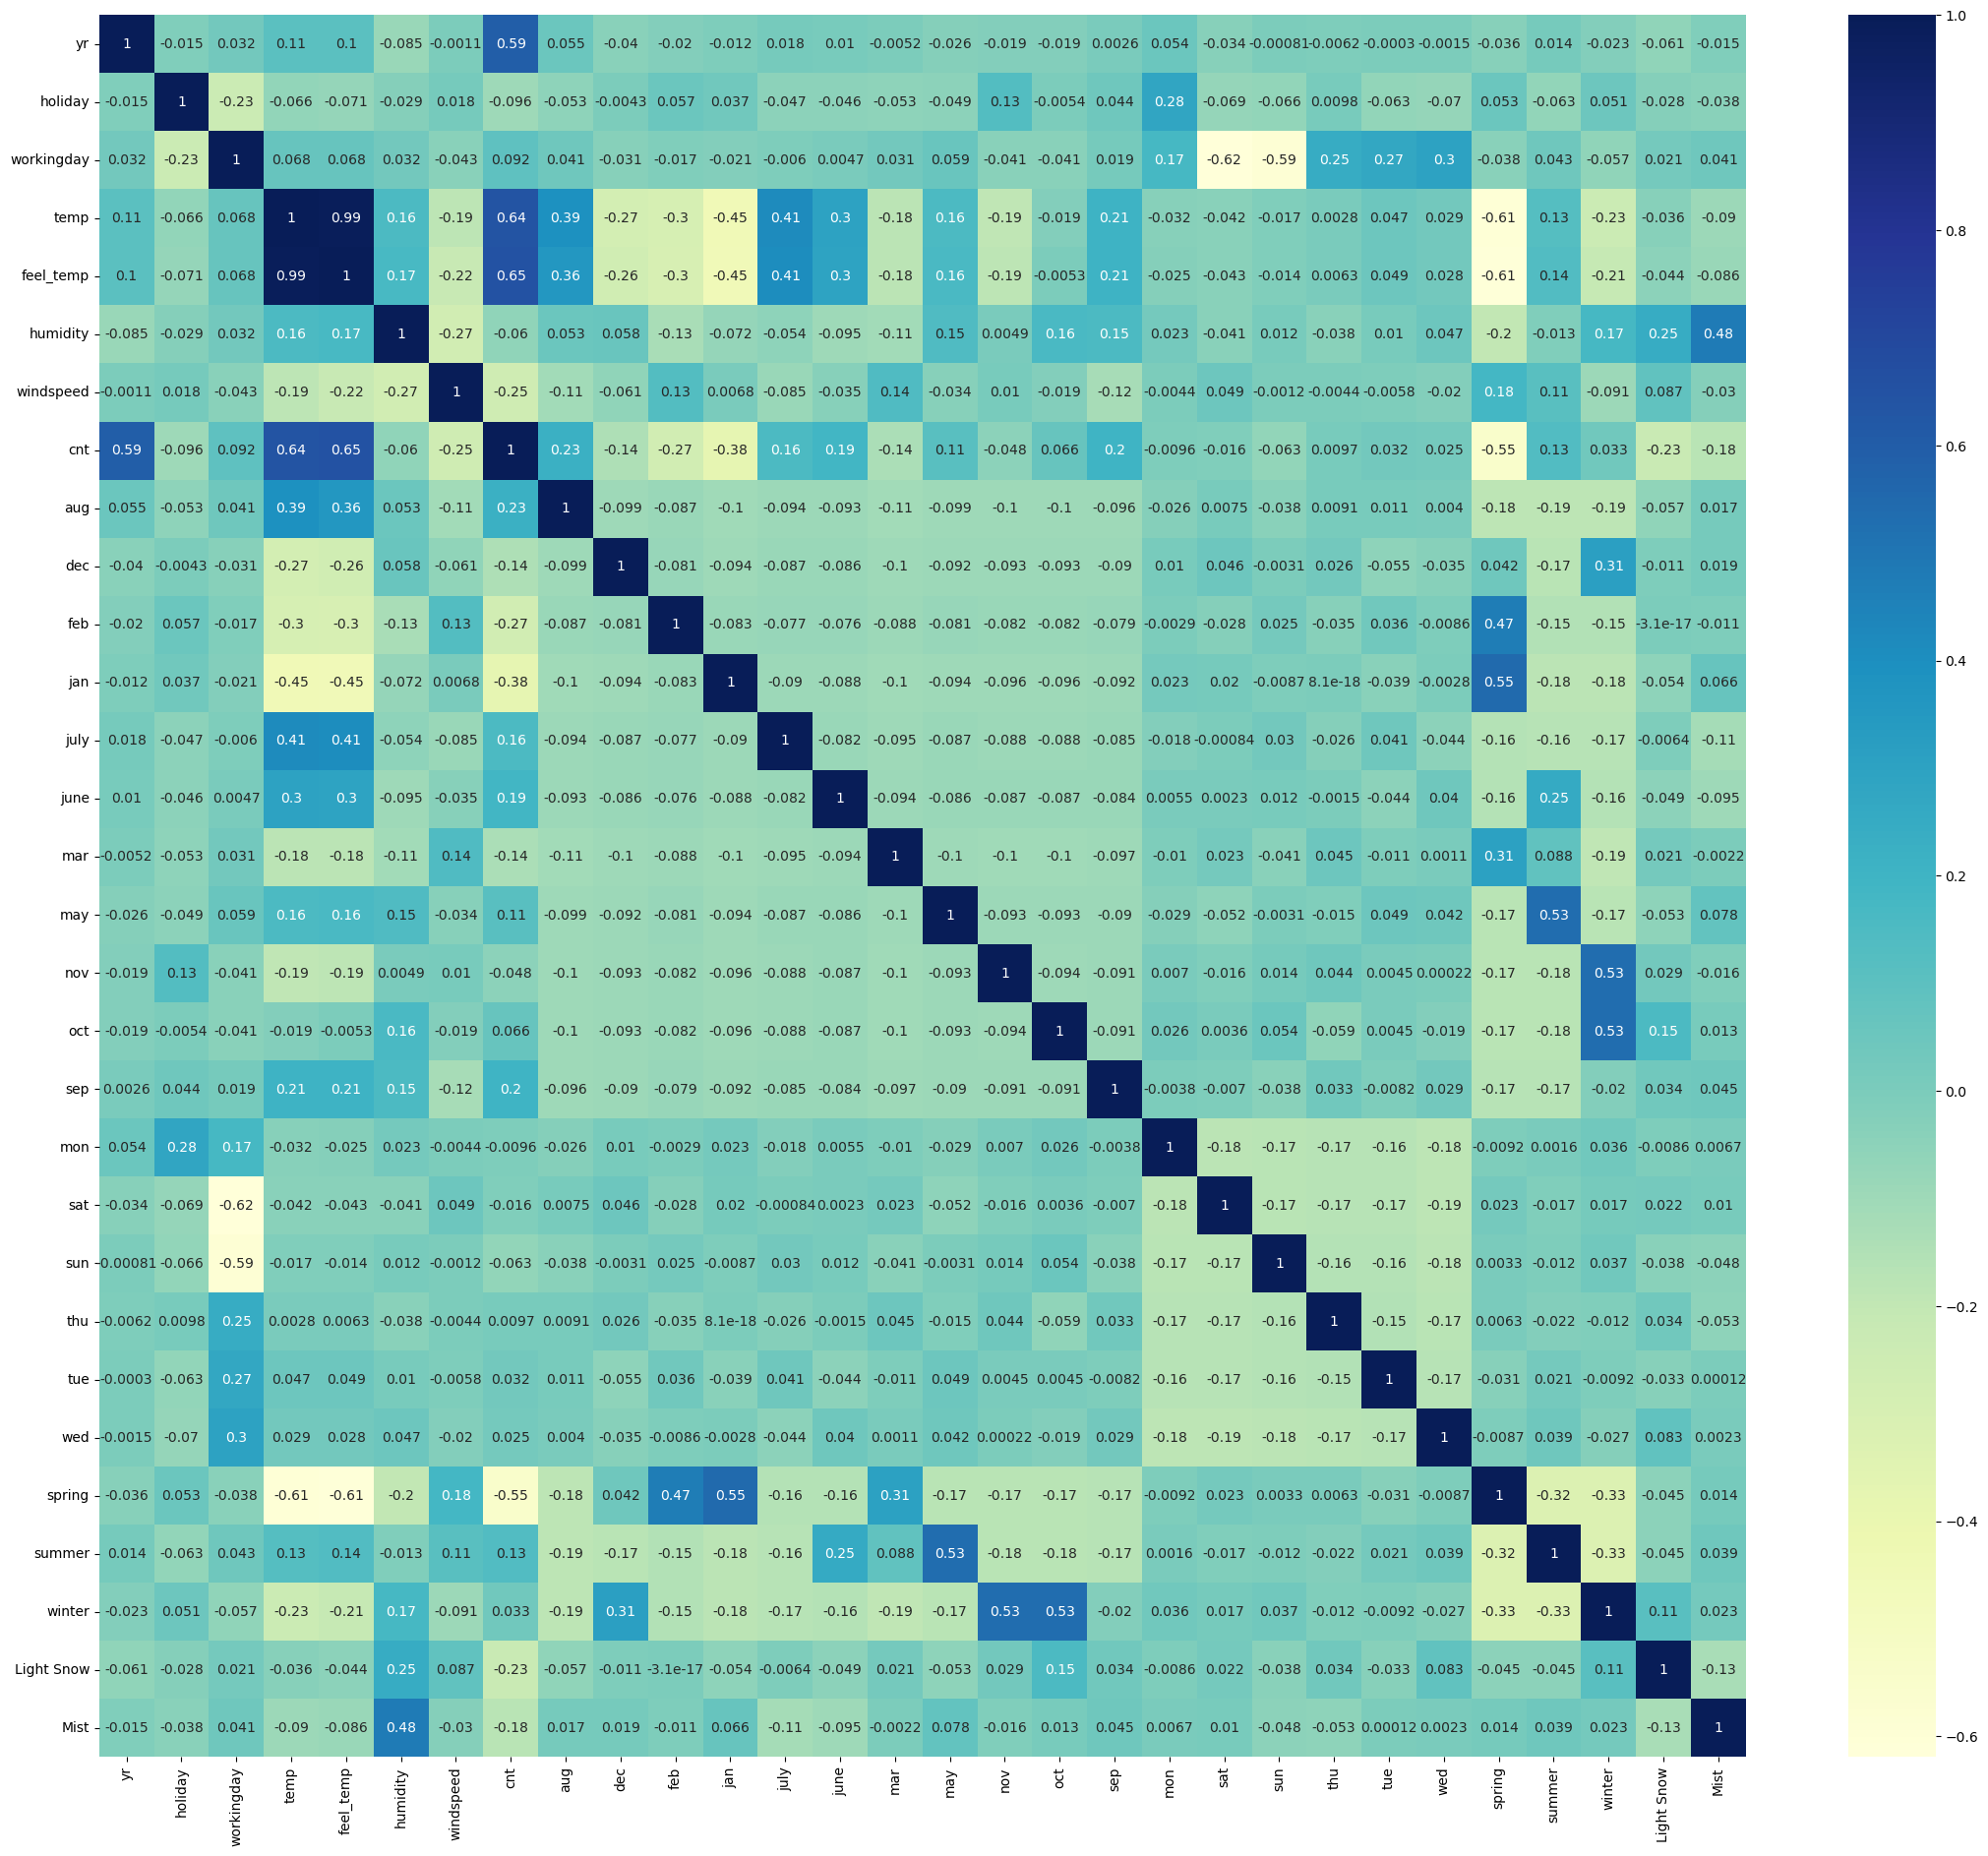

In [53]:
#Checking the correlation coefficient by plotting heatmap:
plt.figure(figsize=(27,23))
sns.heatmap(df_train.corr(), annot=True, cmap='YlGnBu')
plt.show()

<pre>
Upon analysing the correlationship value from the above plot we can say:
- cnt has high correlationship with temp, yr and feel_temp
- temp with feel_temp themselves have a high corr value
- Mist with humidity    
- spring with feb and jan
- summer with may month
- winter with nov and oct

## Section 3: Training the model

#### Dividing into X and y sets and Building the model

In [54]:
y_train = df_train.pop('cnt')
X_train = df_train

<pre>
In sklearn, we have the option to leverage RFE utility that helps drop redundant columns

### Model 1

In [55]:
#Building the model by keeping all the features

#adding the interceptor
X_train_sm_1 = sm.add_constant(X_train)

# creating the model 
lr1 = sm.OLS(y_train, X_train_sm_1)

lr1_model = lr1.fit()

In [56]:
lr1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          8.42e-181
Time:                        09:01:28   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2452      0.035      6.953      0.000       0.176       0.315
yr             0.2322      0.008     28.792      0.000       0.216       0.248
holiday        0.0107      0.024      0.443      0.658      -0.037       0.058
workingday     0.0970      0.012      7.903      0.000       0.073       0.121
temp           0.4013      0.142      2.821      0.005       0.122       0.681
feel_temp      0.0506      0.138      0.366      0.714      -0.221       0.322
humidity      -0.1518      0.039     -3.940      0.000      -0.228      -0.076
windspeed     -0.1844      0.026     -7.003      0.000      -0.236      -0.133
aug            0.0161      0.034      0.473      0.637      -0.051       0.083
dec           -0.0456      0.034     -1.356      0.176      -0.112       0.020
feb           -0.0322      0.033     -0.978      0.329      -0.097       0.032
jan           -0.0626      0.034     -1.864      0.063      -0.129       0.003
july          -0.0393      0.035     -1.116      0.265      -0.108       0.030
june          -0.0017      0.025     -0.067      0.946      -0.051       0.048
mar            0.0013      0.025      0.052      0.958      -0.047       0.050
may            0.0247      0.021      1.169      0.243      -0.017       0.066
nov           -0.0418      0.036     -1.149      0.251      -0.113       0.030
oct            0.0077      0.036      0.215      0.830      -0.063       0.078
sep            0.0818      0.032      2.549      0.011       0.019       0.145
mon           -0.0215      0.015     -1.395      0.164      -0.052       0.009
sat            0.0961      0.014      6.984      0.000       0.069       0.123
sun            0.0415      0.014      2.974      0.003       0.014       0.069
thu           -0.0097      0.016     -0.625      0.532      -0.040       0.021
tue           -0.0193      0.016     -1.242      0.215      -0.050       0.011
wed           -0.0057      0.015     -0.384      0.701      -0.035       0.024
spring        -0.0486      0.030     -1.618      0.106      -0.108       0.010
summer         0.0382      0.026      1.455      0.146      -0.013       0.090
winter         0.1054      0.028      3.770      0.000       0.050       0.160
Light Snow    -0.2567      0.026     -9.712      0.000      -0.309      -0.205
Mist          -0.0610      0.010     -5.845      0.000      -0.082      -0.041
==============================================================================
Omnibus:                       85.143   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.880
Skew:                          -0.809   Prob(JB):                     2.21e-52
Kurtosis:                       5.929   Cond. No.                     1.78e+15
==============================================================================

N

<pre>
Looking at the above stats we have the following values for r2 and adjusted_r2:
    -r2: 0.853
    - Adj. R-squared: 0.845

In [57]:
# As We have included all the features for building the model and predict the dependent variable values, we will now work on dropping insignificant
# variables with the help of automated and manual approach

### Model 2

In [58]:
# Building the model and doing a feature selection using Recursive Feature Elimination method

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [59]:
# Listing what all columns picked, and also viewing their rankings for future purposes
list(zip(X_train.columns[rfe.support_],rfe.ranking_))

[('yr', 1),
 ('holiday', 1),
 ('workingday', 1),
 ('temp', 1),
 ('humidity', 6),
 ('windspeed', 1),
 ('july', 1),
 ('sep', 15),
 ('sat', 4),
 ('sun', 5),
 ('spring', 2),
 ('summer', 1),
 ('winter', 9),
 ('Light Snow', 13),
 ('Mist', 7)]

In [60]:
#Picking the shortlisted columns via RFE 
cols = X_train.columns[rfe.support_]

In [61]:
# Checking the list of rejected columns
X_train.columns[~rfe.support_]

Index(['feel_temp', 'aug', 'dec', 'feb', 'jan', 'june', 'mar', 'may', 'nov',
       'oct', 'mon', 'thu', 'tue', 'wed'],
      dtype='object')

In [62]:
# Building a vif calculator function that will help pick the features from the list
def vif_calculator(data_df):
    vif = pd.DataFrame()
    vif['Features']=data_df.columns
    vif['VIF'] = [variance_inflation_factor(data_df.values, i) for i in range(data_df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif

In [63]:
# Creating a new train dataframe by keeping the features list provided by RFE method
X_train_rfe_1 = X_train[cols]

In [64]:
vif_calculator(X_train_rfe_1)

,Features,VIF
2,workingday,50.69
8,sat,12.20
9,sun,11.79
10,spring,5.02
3,temp,3.62
12,winter,3.49
1,holiday,2.91
11,summer,2.61
4,humidity,1.91
14,Mist,1.57


In [65]:
#Building the model 

#adding the interceptor
X_train_sm_2 = sm.add_constant(X_train_rfe_1)

# creating the model 
lr2 = sm.OLS(y_train, X_train_sm_2)

lr2_model = lr2.fit()

In [66]:
lr2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          1.13e-191
Time:                        09:01:28   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1989      0.028      7.181      0.000       0.144       0.253
yr             0.2297      0.008     28.660      0.000       0.214       0.245
holiday       -0.0190      0.021     -0.892      0.373      -0.061       0.023
workingday     0.0837      0.010      8.672      0.000       0.065       0.103
temp           0.5278      0.033     15.897      0.000       0.463       0.593
humidity      -0.1595      0.037     -4.268      0.000      -0.233      -0.086
windspeed     -0.1806      0.025     -7.110      0.000      -0.231      -0.131
july          -0.0549      0.018     -3.035      0.003      -0.090      -0.019
sep            0.0818      0.016      4.956      0.000       0.049       0.114
sat            0.0937      0.012      8.045      0.000       0.071       0.117
sun            0.0405      0.012      3.304      0.001       0.016       0.065
spring        -0.0554      0.021     -2.694      0.007      -0.096      -0.015
summer         0.0526      0.015      3.553      0.000       0.024       0.082
winter         0.1003      0.017      5.890      0.000       0.067       0.134
Light Snow    -0.2463      0.026     -9.449      0.000      -0.298      -0.195
Mist          -0.0578      0.010     -5.559      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       64.879   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.454
Skew:                          -0.661   Prob(JB):                     3.91e-35
Kurtosis:                       5.390   Cond. No.                     2.24e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.02e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

<pre>
Looking at the above stats we have the following values for r2 and adjusted_r2:
    - r2: 0.847 which is still around 85% 
    - Adj. R-squared: 0.843

The values help us understand that the model is still performing well after optimizing the number of predictor variables.
Upon looking at the VIF calculator, the vaule for workingday is quite high and is 50.69, and hence can be dropped

In [67]:
# Outcome list of independent variables after considering above stats
X_train_rfe_2 = X_train_rfe_1.drop(['workingday'],axis=1)

In [68]:
X_train_rfe_2.head(2)

,yr,holiday,temp,humidity,windspeed,july,sep,sat,sun,spring,summer,winter,Light Snow,Mist
653,1,0,0.509887,0.575354,0.300794,0,0,0,0,0,0,1,0,0
576,1,0,0.815169,0.725633,0.264686,1,0,0,0,0,0,0,0,0


In [69]:
vif_calculator(X_train_rfe_2)

,Features,VIF
3,humidity,28.28
2,temp,16.06
4,windspeed,4.68
9,spring,4.03
11,winter,3.37
10,summer,2.78
13,Mist,2.30
0,yr,2.08
5,july,1.59
6,sep,1.39


### Model 3

In [70]:
#Building the model 

#adding the interceptor
X_train_sm_3 = sm.add_constant(X_train_rfe_2)

# creating the model 
lr3 = sm.OLS(y_train, X_train_sm_3)

lr3_model = lr3.fit()

In [71]:
lr3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          1.13e-191
Time:                        09:01:28   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2826      0.034      8.286      0.000       0.216       0.350
yr             0.2297      0.008     28.660      0.000       0.214       0.245
holiday       -0.1027      0.025     -4.047      0.000      -0.152      -0.053
temp           0.5278      0.033     15.897      0.000       0.463       0.593
humidity      -0.1595      0.037     -4.268      0.000      -0.233      -0.086
windspeed     -0.1806      0.025     -7.110      0.000      -0.231      -0.131
july          -0.0549      0.018     -3.035      0.003      -0.090      -0.019
sep            0.0818      0.016      4.956      0.000       0.049       0.114
sat            0.0100      0.011      0.896      0.371      -0.012       0.032
sun           -0.0432      0.012     -3.744      0.000      -0.066      -0.021
spring        -0.0554      0.021     -2.694      0.007      -0.096      -0.015
summer         0.0526      0.015      3.553      0.000       0.024       0.082
winter         0.1003      0.017      5.890      0.000       0.067       0.134
Light Snow    -0.2463      0.026     -9.449      0.000      -0.298      -0.195
Mist          -0.0578      0.010     -5.559      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       64.879   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.454
Skew:                          -0.661   Prob(JB):                     3.91e-35
Kurtosis:                       5.390   Cond. No.                         19.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<pre>
We have high p value for 'sat' i.e 0.371 (0.371 > 0.05) and high vif for humidity which is 28.28.
Now once we drop the column 'sat' this will change the vif values for all the columns once again.
Therefore, dropping 'sat' from the new set.

In [72]:
X_train_rfe_3 = X_train_rfe_2.drop(['sat'],axis=1)

In [73]:
vif_calculator(X_train_rfe_3)

,Features,VIF
3,humidity,28.28
2,temp,16.03
4,windspeed,4.65
8,spring,4.01
10,winter,3.35
9,summer,2.78
12,Mist,2.30
0,yr,2.08
5,july,1.59
6,sep,1.39


### Model 4

In [74]:
#Building the model 

#adding the interceptor
X_train_sm_4 = sm.add_constant(X_train_rfe_3)

# creating the model 
lr4 = sm.OLS(y_train, X_train_sm_4)

lr4_model = lr4.fit()

In [75]:
lr4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     211.4
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          1.13e-192
Time:                        09:01:29   Log-Likelihood:                 517.45
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     496   BIC:                            -947.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2852      0.034      8.395      0.000       0.218       0.352
yr             0.2295      0.008     28.652      0.000       0.214       0.245
holiday       -0.1046      0.025     -4.141      0.000      -0.154      -0.055
temp           0.5274      0.033     15.888      0.000       0.462       0.593
humidity      -0.1607      0.037     -4.305      0.000      -0.234      -0.087
windspeed     -0.1798      0.025     -7.085      0.000      -0.230      -0.130
july          -0.0546      0.018     -3.020      0.003      -0.090      -0.019
sep            0.0819      0.016      4.964      0.000       0.049       0.114
sun           -0.0451      0.011     -3.970      0.000      -0.067      -0.023
spring        -0.0554      0.021     -2.692      0.007      -0.096      -0.015
summer         0.0526      0.015      3.549      0.000       0.023       0.082
winter         0.1006      0.017      5.908      0.000       0.067       0.134
Light Snow    -0.2460      0.026     -9.438      0.000      -0.297      -0.195
Mist          -0.0577      0.010     -5.544      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       61.439   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.341
Skew:                          -0.616   Prob(JB):                     1.85e-34
Kurtosis:                       5.407   Cond. No.                         19.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<pre>
- All the feature have p value less than 0.05
- However. we have one independent variable 'humidity' with a very high vif, hence dropping this now.

In [76]:
X_train_rfe_4 = X_train_rfe_3.drop(['humidity'],axis=1)

In [77]:
vif_calculator(X_train_rfe_4)

,Features,VIF
2,temp,5.14
3,windspeed,4.60
8,summer,2.22
7,spring,2.11
0,yr,2.07
9,winter,1.82
4,july,1.59
11,Mist,1.55
5,sep,1.34
6,sun,1.18


### Model 5

In [78]:
#Building the model 

#adding the interceptor
X_train_sm_5 = sm.add_constant(X_train_rfe_4)

# creating the model 
lr5 = sm.OLS(y_train, X_train_sm_5)

lr5_model = lr5.fit()

In [79]:
lr5_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     219.8
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          6.45e-190
Time:                        09:01:29   Log-Likelihood:                 508.10
No. Observations:                 510   AIC:                            -990.2
Df Residuals:                     497   BIC:                            -935.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2063      0.029      7.088      0.000       0.149       0.263
yr             0.2334      0.008     28.819      0.000       0.217       0.249
holiday       -0.1057      0.026     -4.114      0.000      -0.156      -0.055
temp           0.4912      0.033     15.034      0.000       0.427       0.555
windspeed     -0.1479      0.025     -5.989      0.000      -0.196      -0.099
july          -0.0496      0.018     -2.701      0.007      -0.086      -0.014
sep            0.0759      0.017      4.536      0.000       0.043       0.109
sun           -0.0485      0.012     -4.207      0.000      -0.071      -0.026
spring        -0.0653      0.021     -3.140      0.002      -0.106      -0.024
summer         0.0464      0.015      3.092      0.002       0.017       0.076
winter         0.0861      0.017      5.070      0.000       0.053       0.119
Light Snow    -0.2904      0.024    -11.928      0.000      -0.338      -0.243
Mist          -0.0835      0.009     -9.670      0.000      -0.101      -0.067
==============================================================================
Omnibus:                       63.147   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.837
Skew:                          -0.632   Prob(JB):                     1.96e-35
Kurtosis:                       5.434   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<pre>
Looking at the below stats:
    - R-squared:0.841    - 	Adj. R-squared	0.83
The vif for temp is high, however, looking at the p-values for both, temp has 0 p-value compared to july. Therefore, dropping the july variable and 
analysing the stats.8

In [80]:
X_train_rfe_5 = X_train_rfe_4.drop(['july'],axis=1)

In [81]:
vif_calculator(X_train_rfe_5)

,Features,VIF
3,windspeed,4.59
2,temp,3.91
0,yr,2.07
6,spring,2.02
7,summer,1.90
8,winter,1.66
10,Mist,1.55
4,sep,1.23
5,sun,1.18
9,Light Snow,1.08


### Model 6

In [82]:
#Building the model 

#adding the interceptor
X_train_sm_6 = sm.add_constant(X_train_rfe_5)

# creating the model 
lr6 = sm.OLS(y_train, X_train_sm_6)

lr6_model = lr6.fit()

In [83]:
lr6_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     236.1
Date:                Wed, 31 Jul 2024   Prob (F-statistic):          1.51e-189
Time:                        09:01:29   Log-Likelihood:                 504.38
No. Observations:                 510   AIC:                            -984.8
Df Residuals:                     498   BIC:                            -933.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1983      0.029      6.806      0.000       0.141       0.256
yr             0.2339      0.008     28.714      0.000       0.218       0.250
holiday       -0.1048      0.026     -4.054      0.000      -0.156      -0.054
temp           0.4786      0.033     14.707      0.000       0.415       0.542
windspeed     -0.1481      0.025     -5.958      0.000      -0.197      -0.099
sep            0.0893      0.016      5.558      0.000       0.058       0.121
sun           -0.0496      0.012     -4.282      0.000      -0.072      -0.027
spring        -0.0541      0.021     -2.637      0.009      -0.094      -0.014
summer         0.0612      0.014      4.362      0.000       0.034       0.089
winter         0.0983      0.016      5.967      0.000       0.066       0.131
Light Snow    -0.2913      0.024    -11.892      0.000      -0.339      -0.243
Mist          -0.0822      0.009     -9.474      0.000      -0.099      -0.065
==============================================================================
Omnibus:                       67.435   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.567
Skew:                          -0.684   Prob(JB):                     1.12e-36
Kurtosis:                       5.433   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<pre>
- We can consider the above model i.e lr6_model as we now have lower or zero p-values which helps us state that the predictor
variables are statistically significant. Further, we have all the preditor's vif < 5 indicating lower multicollinearity.
- Prob (F-statistic): 1.51e-189 i.e. almost 0, stating that the overall model is significant.

In [84]:
# Fetching all the parameter and their coefficients
lr6_model.params

const         0.198266
yr            0.233911
holiday      -0.104837
temp          0.478564
windspeed    -0.148080
sep           0.089297
sun          -0.049628
spring       -0.054078
summer        0.061227
winter        0.098268
Light Snow   -0.291333
Mist         -0.082226
dtype: float64

## Section 4: Residual Analysis

<pre>
So, now to check if the error terms are normally distrbuted (this in fact is one of the major assumption of the linear reg
ression model), we will plot histrogram of the error terms

In [85]:
X_train_sm_6.head()

,const,yr,holiday,temp,windspeed,sep,sun,spring,summer,winter,Light Snow,Mist
653,1.0,1,0,0.509887,0.300794,0,0,0,0,1,0,0
576,1.0,1,0,0.815169,0.264686,0,0,0,0,0,0,0
426,1.0,1,0,0.442393,0.255342,0,0,1,0,0,0,1
728,1.0,1,0,0.245101,0.663106,0,1,1,0,0,0,0
482,1.0,1,0,0.395666,0.188475,0,0,0,1,0,0,1


In [86]:
y_train_pred = lr6_model.predict(X_train_sm_6)

#### Validating Linear Regression Model Assumptions:

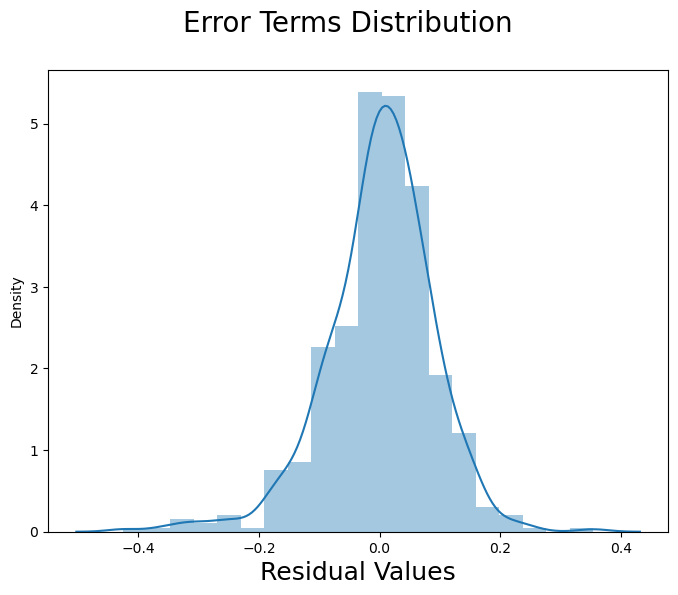

In [87]:
residual = y_train - y_train_pred
fig = plt.figure(figsize=(8,6))
sns.distplot(residual, bins=20)
fig.suptitle('Error Terms Distribution', fontsize=20)
plt.xlabel('Residual Values', fontsize=18)
plt.show()

<pre>
-->As visible form the above plot, the error terms are normally distributed with mean zero

In [88]:
# Proving the assumption that error terms are independent of each other

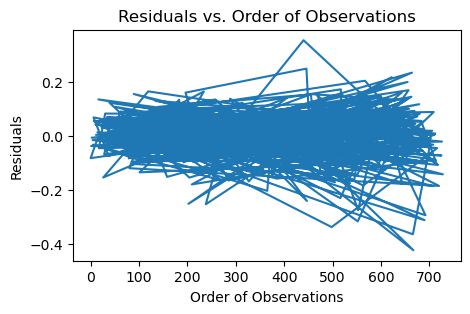

In [89]:
plt.figure(figsize=(5, 3))
plt.plot(residual)
plt.title('Residuals vs. Order of Observations')
plt.xlabel('Order of Observations')
plt.ylabel('Residuals')
plt.show()

<pre>
-->From the above plot of residuals against the order of observations, there seems no patterns over time.

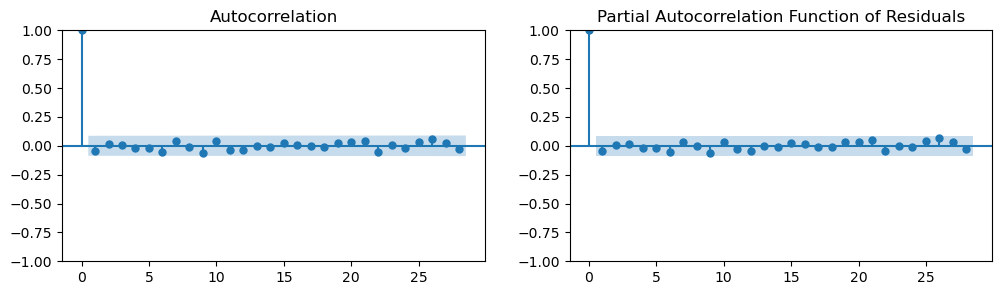

In [90]:
fig, p=plt.subplots(1,2, figsize=(12,3))
plot_acf(residual,ax=p[0])
plt.title('Autocorrelation')
plot_pacf(residual,ax=p[1])
plt.title('Partial Autocorrelation Function of Residuals')
plt.show()

<pre>
Autocorrelation: Is looking for patterns in data over time.
ACF and PACF Plots: As shown in the plots above the autocorrelations are within the confidence bounds (typically shown as dashed lines), 
which suggests that residuals are not significantly autocorrelated.

In [91]:
dw_statistic = durbin_watson(residual)
print(f'Durbin-Watson statistic: {dw_statistic}')

Durbin-Watson statistic: 2.0925319822928214


<pre>
Durbin-Watson Statistic: A value around 2 indicates no autocorrelation. 
    - Values significantly below 2 suggest positive autocorrelation, 
    - Values significantly above 2 suggest negative autocorrelation.

<Axes: >

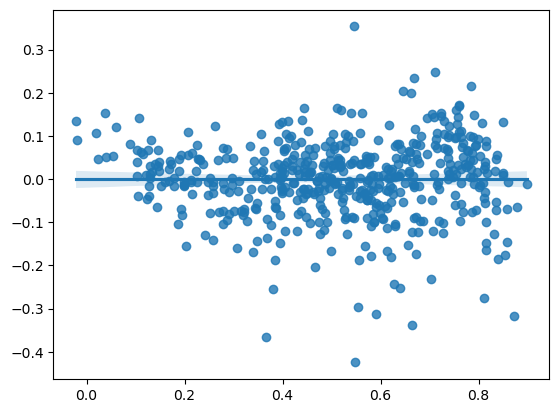

In [92]:
sns.regplot(x=y_train_pred, y=residual)

In [93]:
# Homoscedasticity

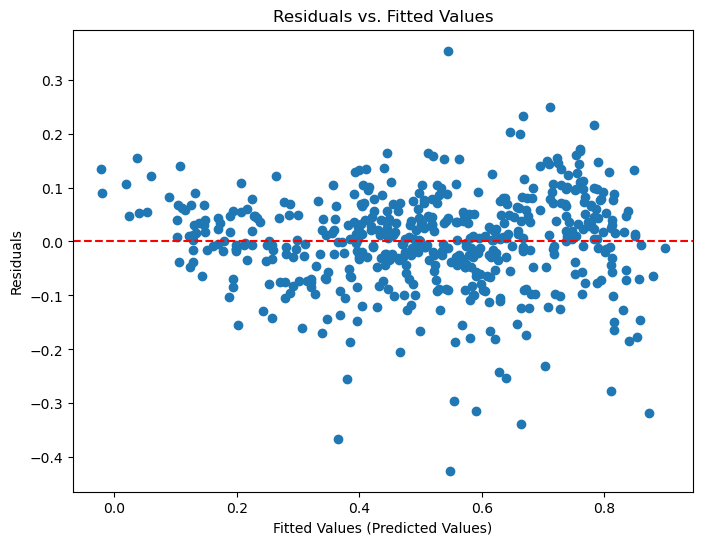

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, residual)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values (Predicted Values)')
plt.ylabel('Residuals')
plt.show()

<pre>
Homoscedasticity: It states that if the residuals are scattered across the horizontal line (y=0) with no clear pattern 
and the spread of the pattern is constant across range of fitted values, it indicates Homoscedasticity. 

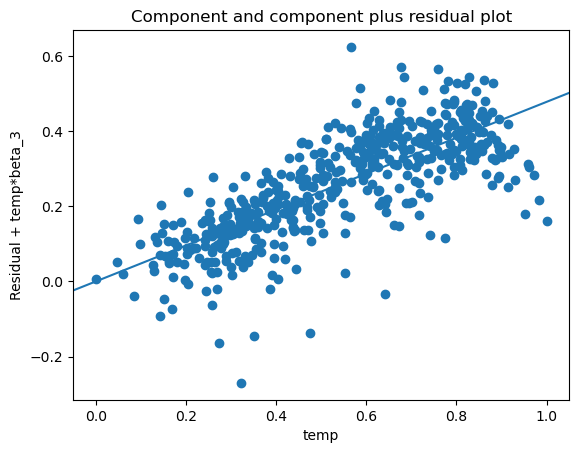

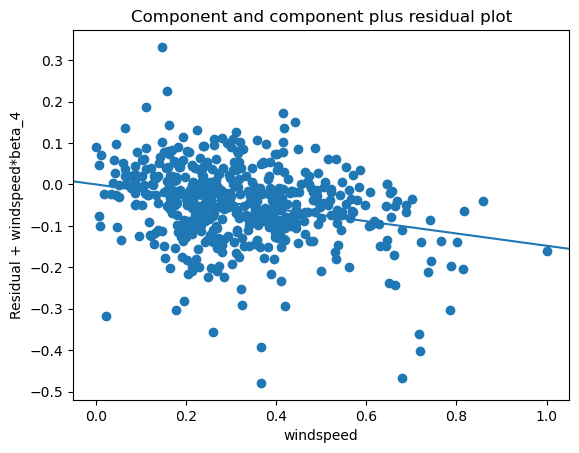

In [95]:
# Linear relationship validation using CCPR/Component and component plus residual plot
sm.graphics.plot_ccpr(lr6_model, 'temp')
sm.graphics.plot_ccpr(lr6_model, 'windspeed')
plt.show()

<pre>
We can observer a linear relationship from above plots

## Section5: Prediction and evaluation on the test set

In [96]:
# Applying scaling on the test dataset
num_vars

['temp', 'feel_temp', 'humidity', 'windspeed', 'cnt']

In [97]:
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [98]:
df_test.describe()

,yr,holiday,workingday,temp,feel_temp,humidity,windspeed,cnt,aug,dec,...,sat,sun,thu,tue,wed,spring,summer,winter,Light Snow,Mist
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.059361,0.086758,...,0.118721,0.146119,0.164384,0.164384,0.100457,0.255708,0.264840,0.232877,0.027397,0.319635
std,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.236840,0.282125,...,0.324202,0.354034,0.371472,0.371472,0.301297,0.437258,0.442259,0.423633,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [99]:
# dividing X and y on test set
y_test = df_test.pop('cnt')
X_test = df_test

In [100]:
col_test = X_train_rfe_5.columns

X_test = X_test[col_test]

X_test_sm = sm.add_constant(X_test)

In [101]:
# prediction y_test
y_test_pred = lr6_model.predict(X_test_sm)

In [102]:
r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
r2

0.805974636697177

In [103]:
print(f'R2 on the test set came out to be :: {round(r2,4)}')

R2 on the test set came out to be :: 0.806


### Model Evaluation

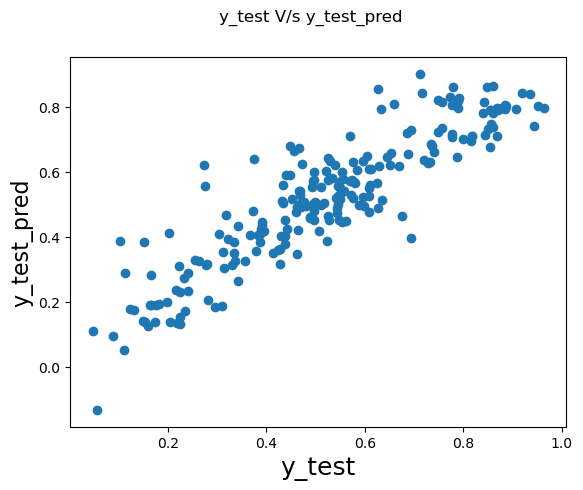

In [104]:
# Plotting y_test and y_test_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test V/s y_test_pred')
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)
plt.show()

#### Formulating the line equation

In [105]:
round(lr6_model.params,4)

const         0.1983
yr            0.2339
holiday      -0.1048
temp          0.4786
windspeed    -0.1481
sep           0.0893
sun          -0.0496
spring       -0.0541
summer        0.0612
winter        0.0983
Light Snow   -0.2913
Mist         -0.0822
dtype: float64

We can see that the equation of our best fitted line is:

$ price = 0.1983 + 0.2339  \times  yr -0.1048  \times  holiday + 0.4786 \times temp -0.1481 \times windspeed +
0.0893 \times sep -0.0496 \times sun -0.0541 \times spring +
0.0612 \times summer + 0.0983 \times winter -0.2913 \times Light Snow -0.0822 \times Mist $

#### Calculating Adjusted r2 on the test set

In [106]:
adj_r2_test_N = X_test.shape[0]

adj_r2_test_P = X_test.shape[1]

adj_r2_test = round(1 - (1-r2)*(adj_r2_test_N-1)/(adj_r2_test_N - adj_r2_test_P - 1),4)
print(f'The value of Adjusted R2 for test data is :: {adj_r2_test}')

The value of Adjusted R2 for test data is :: 0.7957


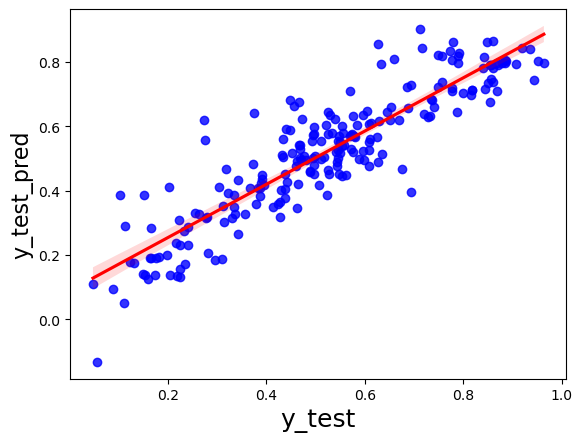

In [107]:
# Visualizing the fit on test data set by plotting a regression plot

plt.figure()
# scatter_kws parameter in Seaborn’s lmplot function allows you to customize the scatter plot style. 
# Specifically, it lets you set various properties for the scatter points, 
# such as color, marker size, and transparency
sns.regplot(x=y_test, y=y_test_pred, ci=95, fit_reg=True,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
fig.suptitle('y_test V/s y_test_pred')
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_test_pred', fontsize=16)
plt.show()

### Following are the stats evaluated from Training and Test Dataset:
    - Train Dataset R2 : 0.839
    - Test Dataset R2 : 0.806
    - Train Dataset Adjusted R2 : 0.836
    - Test Dataset Adjusted R2 : 0.7957

<pre>
Hence, we can say that the demands for rented bikes depends on below list of features:
    
'yr', 'holiday', 'temp', 'windspeed', 'sep', 'sun', 'spring', 'summer',  'winter', 'Light Snow', 'Mist'